In [1]:
import warnings
warnings.filterwarnings("ignore")

%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

import findspark 
findspark.init() # Used to properly connect to Spark Master
import pyspark   # Only run after findspark.init()

from pyspark.sql import SQLContext
from pyspark import SparkContext, SparkConf

conf = SparkConf().set("spark.driver.maxResultSize", "20g") 

sc = SparkContext(appName="RecModel", sparkHome="/usr/local/spark", conf=conf)    
sqlContext = SQLContext(sc)


from pyspark.sql.types import StructType, StructField, IntegerType, FloatType
from pyspark.sql.utils import AnalysisException

import pyspark.sql.functions as sf
from pyspark.sql.types import StringType


from model.als_trainer import ALSTrainer
from pyspark.ml.recommendation import ALSModel

from utils.evaluate import spark_filepath_to_pandas
from utils.evaluate import evaluate

from pyspark.ml.clustering import KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.recommendation import ALSModel

from model.kmeans_trainer import KMeansTrainer

from utils.evaluate import evaluate, spark_filepath_to_pandas
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
target_users  = sqlContext.read.csv("data/target_users.tsv",sep="\t", header=True).repartition(200)

# RecModel: The Recomendation System

In [32]:
class RecModel:
  
  def __init__(self, sqlContext, k=5000, maxIter=20, regParam=0.1, rank=200):
    self.k        = k
    self.maxIter  = maxIter
    self.regParam = regParam
    self.rank     = rank
    
    self.sqlContext = sqlContext
    
    self.kmeans_model = KMeansModel.load(f"models/kmeans_{k}.pkl")
    self.als_model    = ALSModel.load(f"models/asl_{maxIter}_{str(regParam).replace('.','')}_{rank}.pkl")
    
    self.kmeans_train = self.load_cluster_train()
    self.cluster_hist = self.load_cluster_history()
    
    # Simple recommendation for cold start
    top72 = self.cluster_hist.groupBy("item_id").agg(sf.sum("frequency").alias("frequency"))
    top72 = top72.sort(sf.desc("frequency"))
    self.top72 = [str(r.item_id) for r in top72.take(72)]
    
  def kmeans_predict(self, user):
    pass
    
  def load_cluster_train(self):
    user_master  = self.sqlContext.read.csv("data/user_master.tsv",sep="\t", header=True) 
    self.kmeans_train = KMeansTrainer.make_features(user_master)
    return self.kmeans_train
  
  def load_cluster_history(self):
    
    cluster_hist = self.try_load_cluster_hist_from_file()
    if cluster_hist is None:
      cluster_hist = self.setup_cluster_hist_from_start()
      
    return cluster_hist
      
  def try_load_cluster_hist_from_file(self):
    """
    Get cluster_history from file if available
    """
    schema = StructType([
          StructField("prediction", IntegerType()), 
          StructField("item_id", IntegerType()), 
          StructField("frequency", FloatType()),
        ])

    try:
      return self.sqlContext.read.csv(f"data/spark_kmeans_cluster_hist_{self.k}.tsv", 
                                       sep="\t", header=True, schema=schema).repartition(100)
    except AnalysisException:
      print(f"Did not find cluster hist at", f"data/spark_kmeans_cluster_hist_{self.k}.tsv")
    
  
  def setup_cluster_hist_from_start(self):
    """
    Setup cluster history from user master + training data. 
    Essentially count the item purchases per cluster and save it in the cluster_hist table.
    """
    print("Seting up cluster history from start. It should take a few seconds...")    
    
    frequencies  = self.sqlContext.read.csv("data/train_frequencies.tsv",sep="\t", header=True)
    if self.kmeans_train is None:
      self.load_cluster_train()
    all_clusters = self.kmeans_model.transform(self.kmeans_train)
    
    
    cluster_hist = frequencies.join(all_clusters, ["user_id"], how="inner")
    cluster_hist = cluster_hist.groupBy(["prediction","item_id"]).agg(sf.sum("frequency").alias("frequency"))
    cluster_hist = cluster_hist.sort(sf.desc("frequency"))
    
    cluster_hist = cluster_hist.repartition(100)
    print("Saving cluster history to file")
    cluster_hist.write.csv(f"data/spark_kmeans_cluster_hist_{self.k}.tsv", 
                                sep="\t", mode="overwrite", header=True)
    return cluster_hist
  
  
  def recommend_to_subset_of_users(self, users, K=72, append_I=False):
    _I = "I" if append_I else ""
    als_recs = self.als_model.recommendForUserSubset(users, numItems=K)
    als_recs = als_recs.withColumn("als_rec", als_recs.recommendations).drop("recommendations")

    # Since self.kmeans_train has all the users with the features already hot-encoded 
    # the next join speedup the pipeline for `users.` In reality
    # we would have to transform the users features from user_master. 
    k_preds  = self.kmeans_model.transform(self.kmeans_train.join(users, ["user_id"], how="inner"))
    userRecs = (
      self.cluster_hist.join(k_preds, ["prediction"], how="inner")
     .groupby("user_id")
     .agg(sf.collect_list("item_id").alias("k_recs") )
    )

    k_recs = userRecs.withColumn('k_recs', userRecs["k_recs"])
    
    
    def faro_shuffle(k_recs, als_rec, topN72):
      """
      interweave kmeans and ALS recommendation list
      Faro Shuffle: https://en.wikipedia.org/wiki/Faro_shuffle
      """
      _k_recs = k_recs[:K]
      if als_rec is not None:
        _als_rec = [r.item_id for r in als_rec][:K]
        
        # Turns out that Faro Shuffle has not so good of nDCG
        # ret = [r for pair in zip(_als_rec[:K//2], _k_recs[:K//2]) for r in pair]
        ret = _als_rec
        if len(ret)<K:
          # als_recommendation has always 72 items. 
          # kMeans could have less
          ret = ret + _als_rec[len(_k_recs):]
      else:
        ret = [r for r in _k_recs]
        #ret = topN72.split(",")
        if len(ret)<K:
          ret = ret + topN72.split(",")[:K-len(ret)]

      return ','.join([_I+str(r) for r in ret])
    faro_shuffle_udf = sf.udf(faro_shuffle, StringType()) 

    both_recs = k_recs.join(als_recs, ["user_id"], how="outer")
    both_recs = both_recs.withColumn("topN", sf.lit(",".join(self.top72) ))
    both_recs = both_recs.withColumn("recommend_items", 
                                     faro_shuffle_udf("k_recs", "als_rec", "topN")
                                    ).drop("k_recs").drop("als_rec").drop("topN")
    
    return both_recs

In [58]:
recModel = RecModel(sqlContext, k=3000, rank=100)
recs = recModel.recommend_to_subset_of_users(target_users, append_I=False)
recs = recModel.recommend_to_subset_of_users(target_users, append_I=False)
recs.write.csv(f"data/spark_hybrid_model_target_users.tsv", sep="\t", mode="overwrite", header=True)

## Comparing Different Ranks and Number of Clusters

In [72]:
recModel = RecModel(sqlContext, k=3000, rank=100)
recs = recModel.recommend_to_subset_of_users(target_users, append_I=False)
recs.write.csv(f"data/spark_hybrid_model_target_users.tsv", sep="\t", mode="overwrite", header=True)

filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

250,000 / 250,343 (99.86)%
Stoping Writer
Entropy: 12.204594110253886
nDCG avg:0.007964


In [74]:
recModel = RecModel(sqlContext, k=5000, rank=100)
recs = recModel.recommend_to_subset_of_users(target_users, append_I=False)
recs.write.csv(f"data/spark_hybrid_model_target_users.tsv", sep="\t", mode="overwrite", header=True)

filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

250,000 / 250,343 (99.86)%
Stoping Writer
Entropy: 12.219242521785768
nDCG avg:0.007972


In [75]:
recModel = RecModel(sqlContext, k=3000, rank=200)
recs = recModel.recommend_to_subset_of_users(target_users, append_I=False)
recs.write.csv(f"data/spark_hybrid_model_target_users.tsv", sep="\t", mode="overwrite", header=True)

filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

250,000 / 250,343 (99.86)%
Stoping Writer
Entropy: 12.437360204779186
nDCG avg:0.007957


In [77]:
recModel = RecModel(sqlContext, k=5000, rank=200)
recs = recModel.recommend_to_subset_of_users(target_users, append_I=False)
recs.write.csv(f"data/spark_hybrid_model_target_users.tsv", sep="\t", mode="overwrite", header=True)

filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

250,000 / 250,343 (99.86)%
Stoping Writer
Entropy: 12.45401474738657
nDCG avg:0.007965


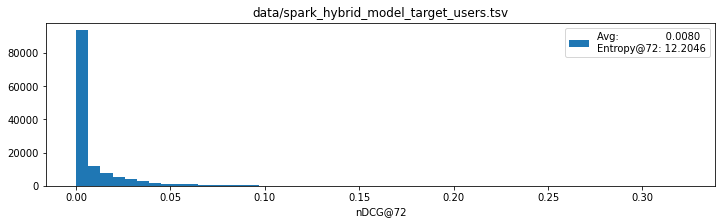

In [73]:
# k = 100 RecModel(sqlContext, k=3000, rank=100)
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=50, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

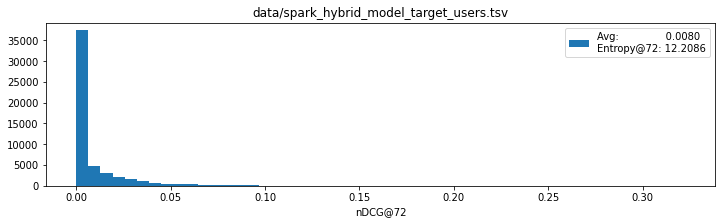

In [69]:
# k = 20 
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=50, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

In [64]:
filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

9,000 / 10,000 (90.00)%
Stoping Writer
Entropy: 12.184915426711873
nDCG avg:0.008087


In [56]:
filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

0 / 1,000 (0.00)%
Stoping Writer
Entropy: 12.04902999025668
nDCG avg:0.00606


In [7]:
filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

0 / 1,000 (0.00)%
Stoping Writer
Entropy: 12.03475684109685
nDCG avg:0.005958


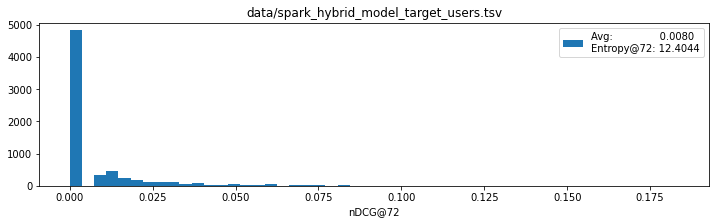

In [243]:
# k = 20 
avg = metrics.nDCGs.mean()
_ = plt.figure(figsize=(12,3))
_ = plt.hist(metrics.nDCGs, bins=50, label=f"Avg:{avg:>21.4f}\nEntropy@72: {entropy:.4f}")
plt.title(f"{filepath}")
plt.xlabel("nDCG@72")
_ = plt.legend()

In [12]:
filepath = f"data/spark_hybrid_model_target_users.tsv"
nDCGs, entropy, globalVar = evaluate(filepath,  spark_file=True, spark_SQLContext=sqlContext)

metrics = pd.DataFrame(nDCGs, columns=["user_id", "nDCGs"])
print(f"nDCG avg:{metrics.nDCGs.mean():.4}")

0 / 1,000 (0.00)%
Stoping Writer
Entropy: 8.853704146456511
nDCG avg:0.01111


## Prep Submission

In [33]:
recModel = RecModel(sqlContext, k=5000, rank=200)

In [34]:
recs = recModel.recommend_to_subset_of_users(target_users, append_I=True)

In [35]:
recs = recs.repartition(1)

In [36]:
recs.write.csv(f"data/target_users_submission_k5000_r200.tsv", sep="\t", mode="overwrite", header=True)

In [54]:
submission = sqlContext.read.csv("data/target_users_submission_k5000_r200.tsv",
                                 sep="\t", header=True).repartition(200)

In [55]:
submission.count()

250343

In [56]:
submission.take(1)

[Row(user_id='1253778', recommend_items='I77219,I74918,I72457,I75255,I70197,I83904,I68683,I261183,I330923,I339673,I85802,I323398,I79941,I265341,I88522,I81491,I111186,I98924,I287811,I82860,I222602,I110613,I78276,I80529,I133078,I77158,I280182,I269055,I72579,I18903,I232266,I103060,I196962,I213495,I148655,I98788,I348943,I77172,I8139,I78823,I334471,I302522,I68282,I67227,I85126,I51120,I121740,I112522,I235549,I122993,I184195,I189341,I201228,I89142,I288697,I328322,I481,I89467,I74342,I49293,I76426,I16755,I89117,I16787,I76294,I80492,I225744,I167115,I89484,I39030,I32750,I197887')]